In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import tqdm.notebook as tqdm
import os
import pandas as pd
from PIL import Image
import os
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [9]:
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),  # Lower resolution for faster training
    transforms.ToTensor()
])

class CelebAFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_names = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_names[idx])
        image = default_loader(img_path)  # PIL image
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label
    
image_folder = r"C:\Users\isaac\dev\UMN_CSCI_Undergrad\CSCI5527\Project\data\img_align_celeba_resized"
print("Files:", os.listdir(image_folder)[:5])
dataset = CelebAFolderDataset(image_folder, transform=transform)
#dataset = datasets.CelebA(root='./data', split='train', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


Files: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


In [10]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(BetaVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # [B, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # [B, 128, 8, 8]
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # [B, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # [B, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  # [B, 3, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
def beta_vae_loss(recon_x, x, mu, logvar, beta=4):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
vae = BetaVAE(latent_dim=512).to(device)
print(vae)
print(f"Number of parameters: {sum(p.numel() for p in vae.parameters())}")
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

Using device: cuda
BetaVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=8192, out_features=512, bias=True)
  (fc_logvar): Linear(in_features=8192, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=8192, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(128, 8, 8))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)
Number of param

In [12]:
epochs = 20
losses = []

for epoch in tqdm.tqdm(range(epochs), desc="Training"):
    vae.train()
    total_loss = 0
    for images, _ in tqdm.tqdm(dataloader, desc="Batch", leave=False):
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = beta_vae_loss(recon_images, images, mu, logvar, beta=4)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(dataloader.dataset))
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset):.4f}")


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 1, Loss: 364.5434


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 2, Loss: 276.1332


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 3, Loss: 265.3880


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 4, Loss: 261.3906


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 5, Loss: 258.9237


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 6, Loss: 257.0042


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 7, Loss: 255.6136


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 8, Loss: 254.4649


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 9, Loss: 253.3948


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 10, Loss: 252.4294


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 11, Loss: 251.5595


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 12, Loss: 250.8474


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 13, Loss: 250.3564


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 14, Loss: 249.7402


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 15, Loss: 249.4865


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 16, Loss: 249.0591


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 17, Loss: 248.7543


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 18, Loss: 248.4518


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 19, Loss: 248.2252


Batch:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 20, Loss: 247.9037


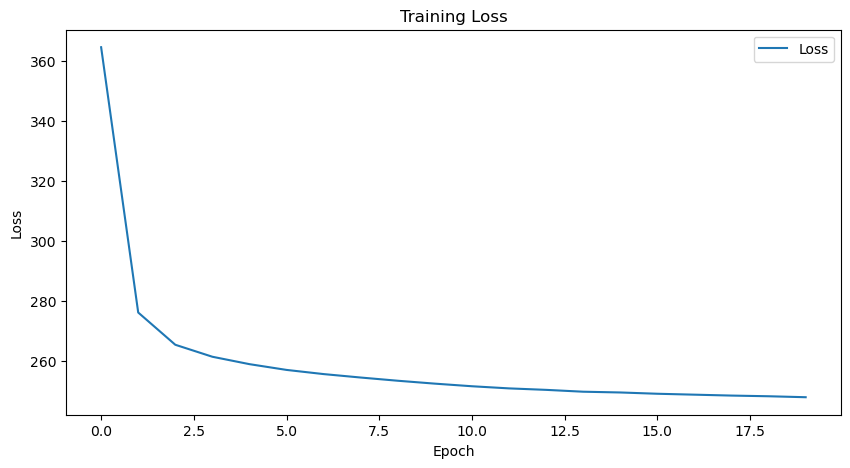

In [13]:
# plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(vae.state_dict(), "beta_vae.pth")

In [ ]:
attribute_names = [
    "5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald", "Bangs",
    "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair", "Bushy_Eyebrows",
    "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", "High_Cheekbones",
    "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard", "Oval_Face", "Pale_Skin",
    "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair",
    "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace",
    "Wearing_Necktie", "Young"
]

df = pd.read_csv(r"C:\Users\isaac\dev\UMN_CSCI_Undergrad\CSCI5527\Project\data\list_attr_celeba.txt", sep="\s+", header=None, skiprows=1)
df.columns = ["filename"] + attribute_names

with_glasses = df[df["Eyeglasses"] == 1].head(2000)
without_glasses = df[df["Eyeglasses"] == -1].head(2000)

subset_df = pd.concat([with_glasses, without_glasses]).sample(frac=1).reset_index(drop=True)
subset_df = subset_df[["filename", "Eyeglasses"]]
subset_df

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
C:\Users\isaac\AppData\Local\Temp\ipykernel_26356\2615119563.py:15: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(r"C:\Users\isaac\dev\UMN_CSCI_Undergrad\CSCI5527\Project\data\list_attr_celeba.txt", sep="\s+", header=None, skiprows=1)


,filename,Eyeglasses
0,002104.jpg,-1
1,029271.jpg,1
2,000465.jpg,-1
3,014640.jpg,1
4,007815.jpg,1
...,...,...
3995,001246.jpg,-1
3996,001235.jpg,-1
3997,000165.jpg,-1
3998,020673.jpg,1


In [ ]:
class CelebASelectiveDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx]["filename"]
        label = self.df.iloc[idx]["Eyeglasses"]
        img_path = os.path.join(self.root_dir, filename)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor()
])

selective_dataset = CelebASelectiveDataset(subset_df, root_dir=r"C:\Users\isaac\dev\UMN_CSCI_Undergrad\CSCI5527\Project\data\img_align_celeba_resized", transform=transform)
selective_loader = DataLoader(selective_dataset, batch_size=64, shuffle=False)

vae.eval()
latents = []
labels = []

with torch.no_grad():
    for images, y in tqdm.tqdm(selective_loader):
        images = images.to(device)
        mu, _ = vae.encode(images)
        latents.append(mu.cpu())
        labels.append(y)

latents = torch.cat(latents, dim=0)   # Shape: [4000, latent_dim]
labels = torch.cat(labels, dim=0)     # Shape: [4000]


  0%|          | 0/63 [00:00<?, ?it/s]

In [31]:
torch.save(latents, "eyeglasses_latents.pt")
torch.save(labels, "eyeglasses_labels.pt")

In [ ]:
X = torch.load("eyeglasses_latents.pt").numpy()
y = torch.load("eyeglasses_labels.pt").numpy()

y = (y == 1).astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.8387
Recall: 0.7984
Precision: 0.8543
F1 Score: 0.8254


In [ ]:
eyeglasses_direction = clf.coef_[0].copy()
eyeglasses_direction /= np.linalg.norm(eyeglasses_direction) 

eyeglasses_direction = torch.tensor(eyeglasses_direction, dtype=torch.float32)

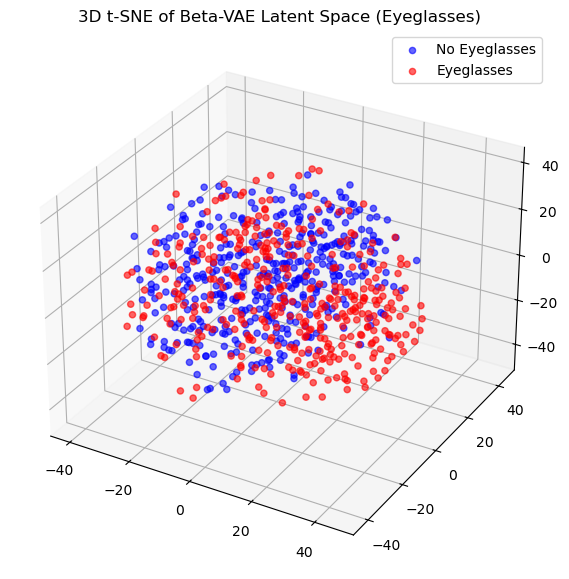

In [ ]:

# Run t-SNE with 3 components
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
X_tsne_3d = tsne.fit_transform(X_test)

# Separate the points by class
eyeglasses = X_tsne_3d[y_test == 1]
no_eyeglasses = X_tsne_3d[y_test == 0]

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(no_eyeglasses[:, 0], no_eyeglasses[:, 1], no_eyeglasses[:, 2], 
           c='blue', label='No Eyeglasses', alpha=0.6)
ax.scatter(eyeglasses[:, 0], eyeglasses[:, 1], eyeglasses[:, 2], 
           c='red', label='Eyeglasses', alpha=0.6)

ax.set_title("3D t-SNE of Beta-VAE Latent Space (Eyeglasses)")
ax.legend()
plt.show()

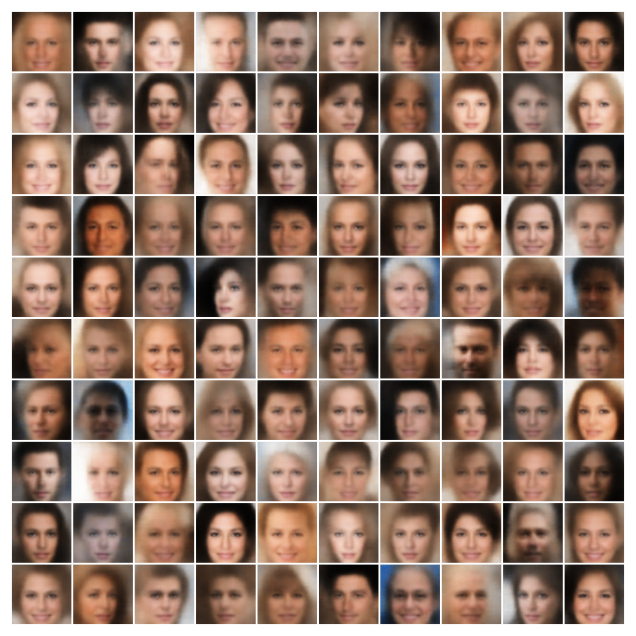

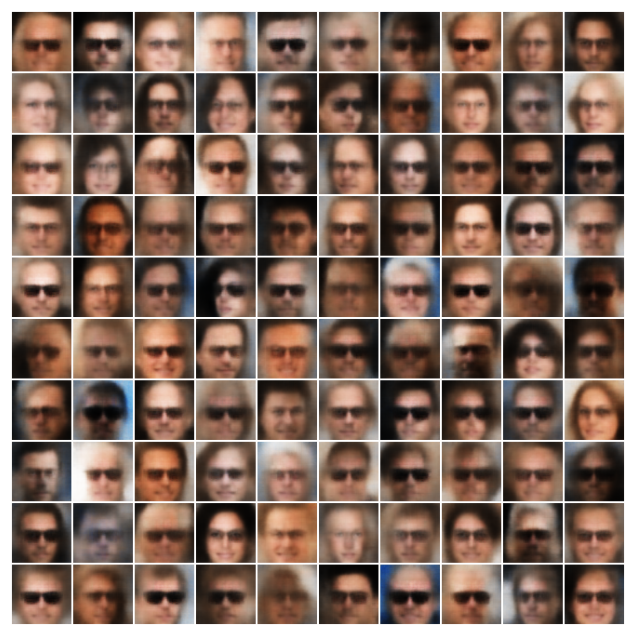

In [ ]:
latent_dim = 512         
grid_size = 10           
alpha = 25             
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


vae.eval()
eyeglasses_direction = eyeglasses_direction.to(device)
z = torch.randn(grid_size * grid_size, latent_dim).to(device)

with torch.no_grad():
    originals = vae.decode(z).cpu()

z_edited = z + alpha * eyeglasses_direction.unsqueeze(0)  # [B, latent_dim]

with torch.no_grad():
    edited = vae.decode(z_edited).cpu()


def show_grid(images, title):
    grid = make_grid(images, nrow=grid_size, pad_value=1)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

show_grid(originals, "Original Samples")
show_grid(edited, "With Eyeglasses (Latent Edit)")